#Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Data Science Portfolio/Brain Tumor Detection/Brain_MRI/

/content/drive/MyDrive/Data Science Portfolio/Brain Tumor Detection/Brain_MRI


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import zipfile
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from utilities import DataGenerator, focal_tversky, tversky_loss, tversky, prediction# utilities contains code for custom loss function & custom data generator
import os
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

# Data Exploration

In [ ]:
# data containing path to brain mri & their masks
brain_df = pd.read_csv('data_mask.csv')
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.drop(["patient_id"], axis = 1, inplace = True)

In [ ]:
# check mask balance
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

In [ ]:
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,190,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 5, opacity = 0.7)
fig.show()

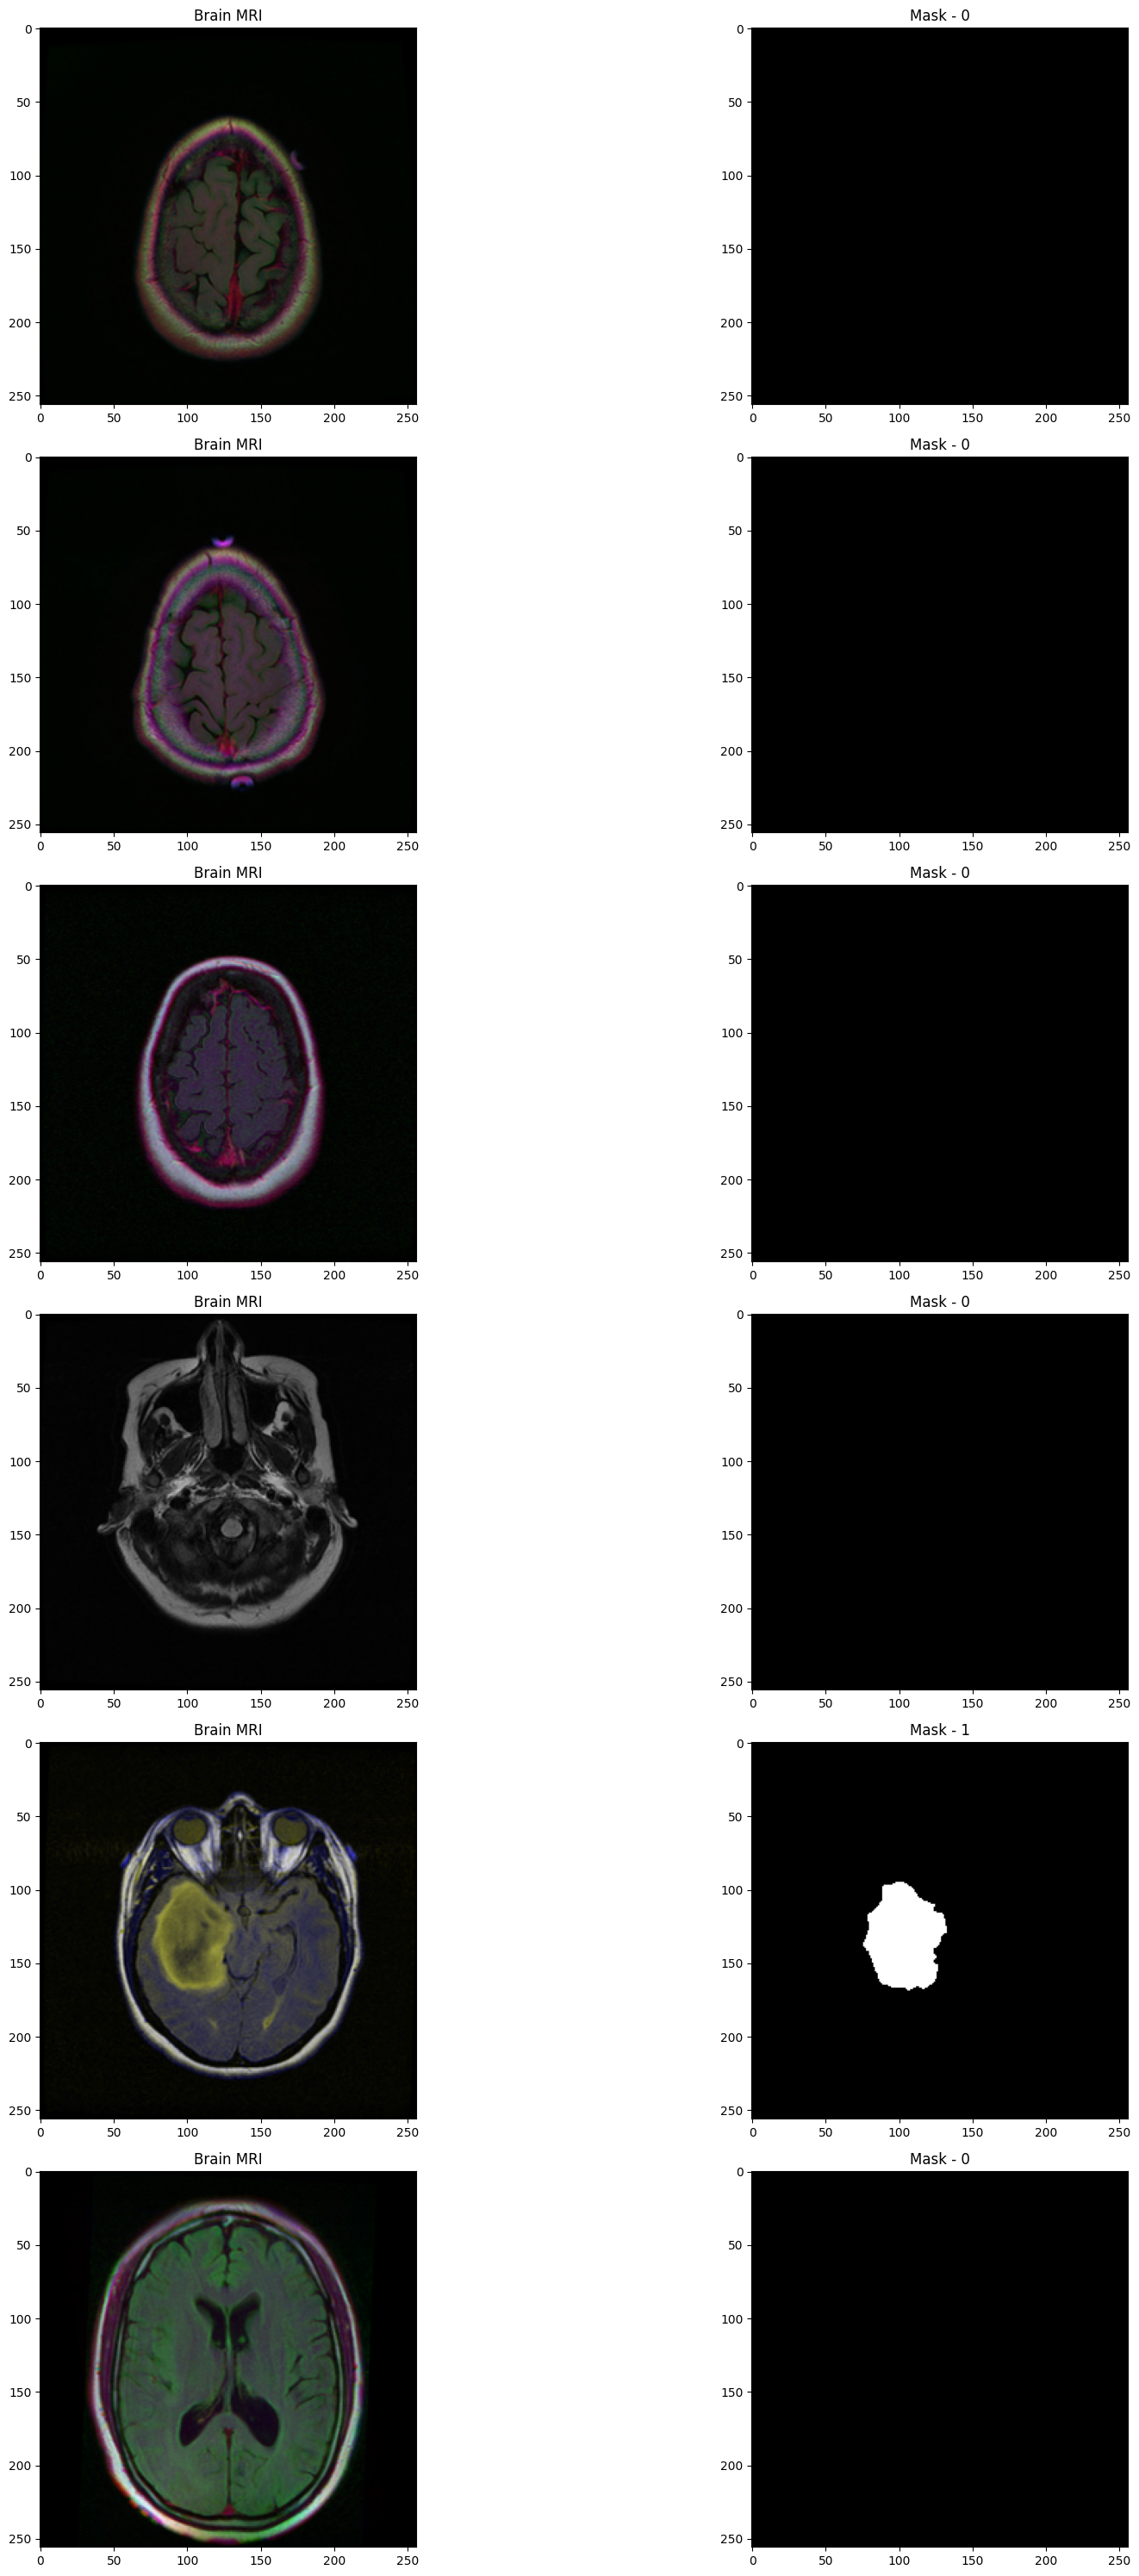

In [ ]:
# visualize image mri and its mask
fig, axs = plt.subplots(6, 2, figsize=(20,30))

for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[x,0].set_title("Brain MRI")
  axs[x,0].imshow(cv2.imread(brain_df["image_path"][i]))
  axs[x,1].set_title("Mask - " +str(brain_df["mask"][i]))
  axs[x,1].imshow(cv2.imread(brain_df["mask_path"][i]))
fig.tight_layout()


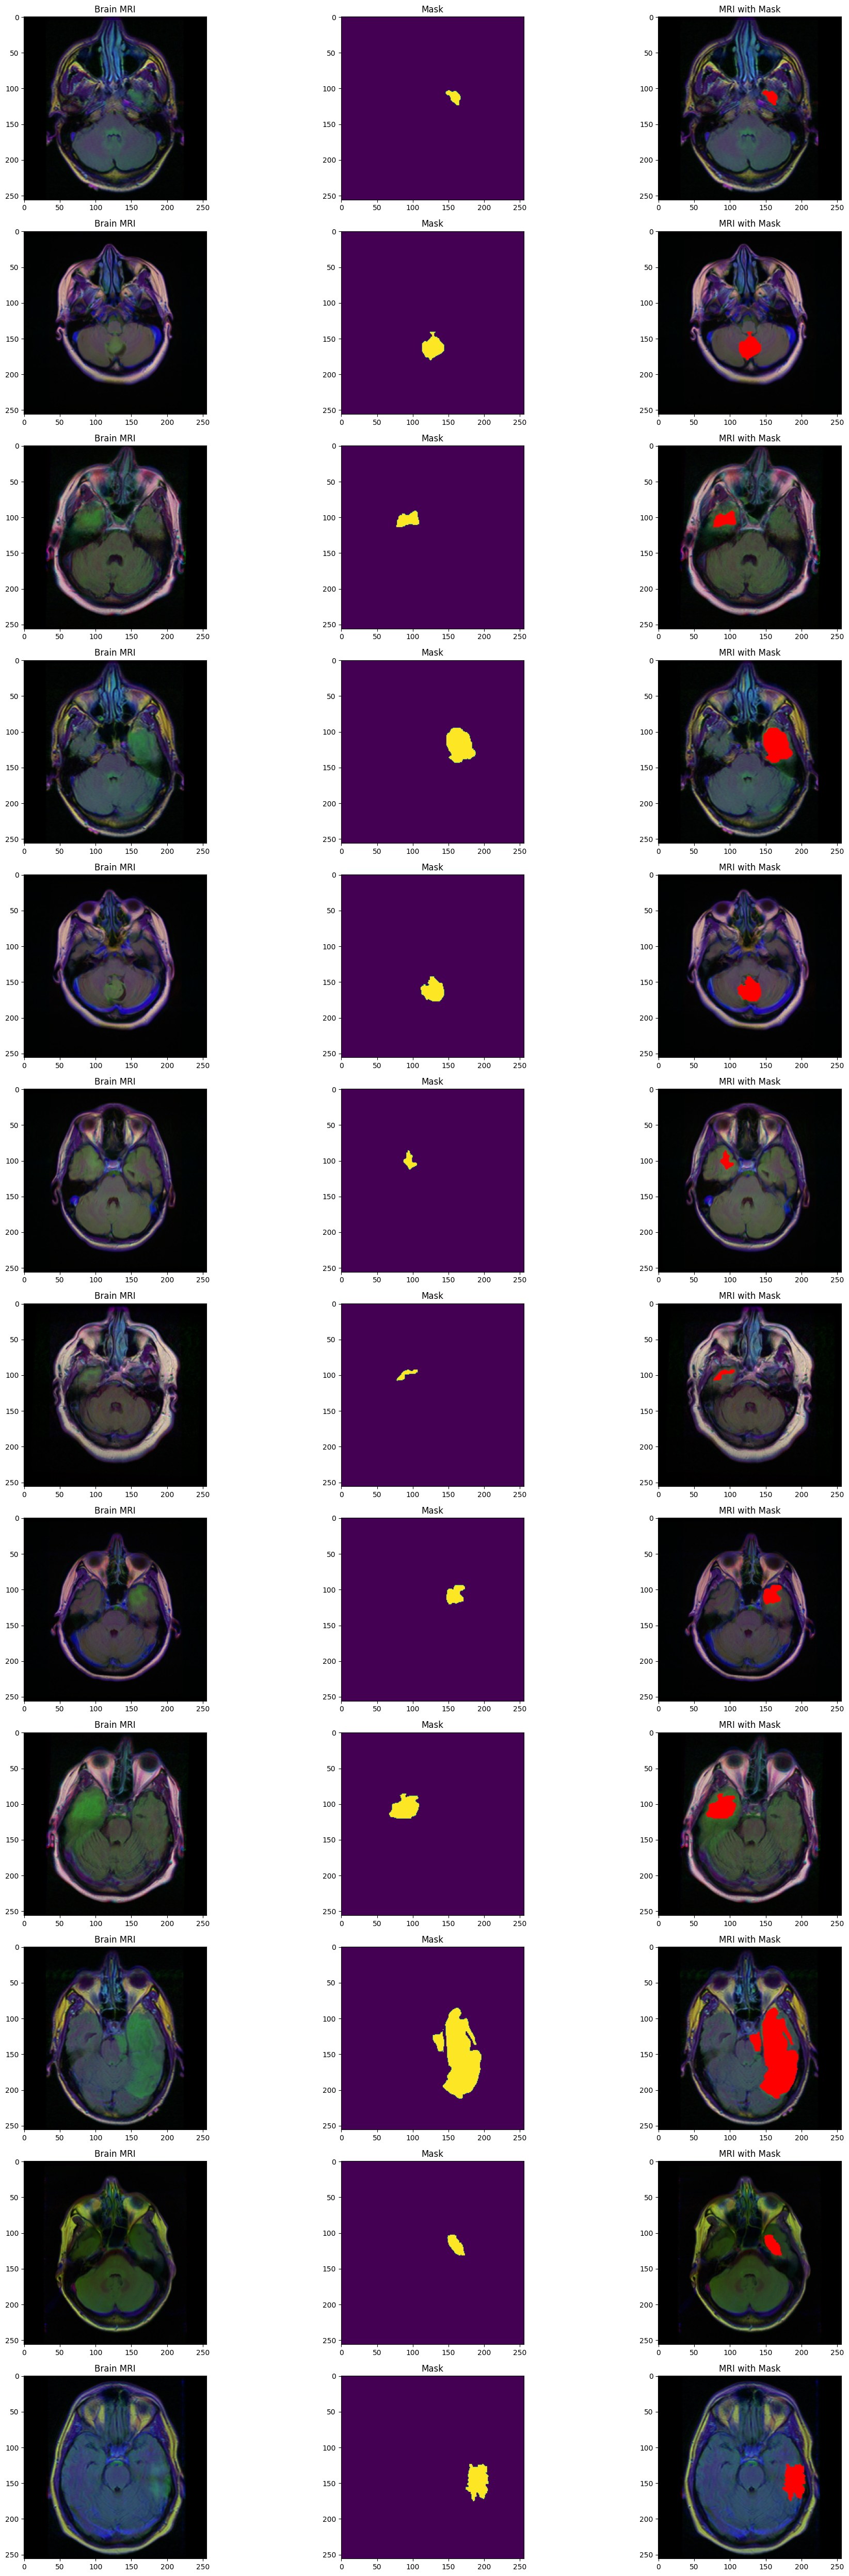

In [ ]:
fig, axs = plt.subplots(12, 3, figsize=(20, 50))

count = 0
for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 12:
        img = io.imread(brain_df["image_path"][i])

        axs[count, 0].set_title('Brain MRI')
        axs[count, 0].imshow(img)

        mask = io.imread(brain_df["mask_path"][i])

        axs[count, 1].set_title('Mask')
        axs[count, 1].imshow(mask)

        img[mask == 255] = (255, 0, 0)

        axs[count, 2].set_title('MRI with Mask')
        axs[count, 2].imshow(img)

        count += 1

fig.tight_layout()

# Data Preparation

In [ ]:
brain_df_train = brain_df.copy()

In [ ]:
# convert to str to use categorical mode in flow_from_dataframe
brain_df_train["mask"] = brain_df_train["mask"].apply(lambda x : str(x))

In [ ]:
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

In [ ]:
train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = '.',
x_col = 'image_path',
y_col = 'mask',
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "categorical",
target_size = (256,256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = '.',
x_col = 'image_path',
y_col = 'mask',
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "categorical",
target_size = (256,256))

# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = '.',
x_col = 'image_path',
y_col = 'mask',
batch_size = 16,
shuffle = False,
class_mode ='categorical',
target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


#ResNet 50 Model For Tumor Detection

In [ ]:
# get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# freeze model weights except last 4 layers
for layer in basemodel.layers[:-4]:
  layers.trainable = False

In [ ]:
# add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ['accuracy'])

In [ ]:
# use early stopping based on the validation loss plateau
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the model with the lowest validation loss
checkpointer = ModelCheckpoint(filepath = 'classifier_resnet_weights.hdf5', verbose = 1, save_best_only = True)

In [ ]:
# history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 50, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

In [ ]:
# # save the model architecture to json file
# model_json = model.to_json()

# with open("classifier_resnet_model.json", "w") as json_file:
#   json_file.write(model_json)

#Model Evaluation

In [ ]:
# load model & weights
with open("classifier_resnet_model.json","r") as json_file:
  json_savedModel = json_file.read()

model = keras.models.model_from_json(json_savedModel)
model.load_weights("classifier_resnet_weights.hdf5")
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make predictions
test_predict = model.predict(test_generator, steps = test_generator.n //16, verbose = 1)

36/36 [==============================] - 418s 12s/step


In [ ]:
test_predict

array([[9.9999994e-01, 9.2031209e-09],
       [1.1069040e-03, 9.9889314e-01],
       [9.9609011e-01, 3.9098025e-03],
       ...,
       [9.8738599e-01, 1.2614047e-02],
       [9.9997193e-01, 2.8039272e-05],
       [9.6546805e-01, 3.4532014e-02]], dtype=float32)

In [ ]:
# obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1',
       '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1',
       '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1',
       '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1',
       '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0

In [ ]:
original = np.array(test['mask'][:len(predict)])
len(original)

576

In [ ]:
accuracy = accuracy_score(original, predict)
accuracy

0.9496527777777778

<Axes: >

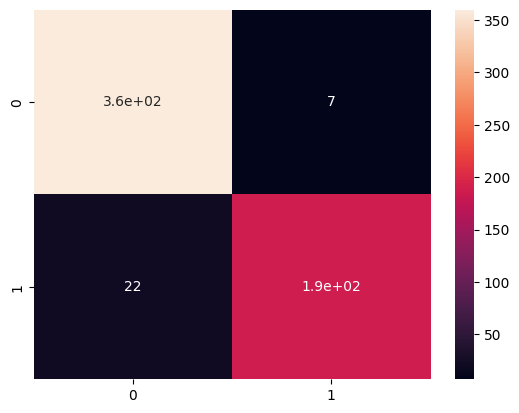

In [ ]:
cm = confusion_matrix(original, predict)
sns.heatmap(cm, annot = True)
# overall misclassifed 29 samples

In [ ]:
report = classification_report(original, predict)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       367
           1       0.96      0.89      0.93       209

    accuracy                           0.95       576
   macro avg       0.95      0.94      0.94       576
weighted avg       0.95      0.95      0.95       576



# Segmentation Model To Localize Tumor

## Data Preparation

In [ ]:
# get dataframe which have tumor
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 3)

In [ ]:
brain_df_mask.head()

image_path  \
445  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif   
507  TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif   
551  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif   
555  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif   
617  TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif   

                                             mask_path  mask  
445  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...     1  
507  TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...     1  
551  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...     1  
555  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...     1  
617  TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...     1

In [ ]:
# split data into train and test
X_train, X_val = train_test_split(brain_df_mask, test_size = 0.15)
X_test, X_val = train_test_split(X_val, test_size = 0.5)

In [ ]:
# create separate list for imageid, classid to pass into generator
train_ids = list(X_train["image_path"])
train_mask = list(X_train["mask_path"])

val_ids = list(X_val["image_path"])
val_mask = list(X_val["mask_path"])

In [ ]:
training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

##Build Resunet Model

In [ ]:
# create residual block
def resblock(X, f):

  # make a copy of input
  X_copy = X

  # main path

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # short path
  # incase the size didn't match for adding
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# input tensor shape
X_input = Input(input_shape)

# stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# stage 5 (bottle neck)
conv5_in = resblock(pool_4, 256)

# upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# final output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
# compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights_seg.hdf5", verbose=1, save_best_only=True)

In [ ]:
# history = model_seg.fit(training_generator, epochs = 50, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# # save the model architecture to json file for future use
# model_json = model_seg.to_json()
# with open("ResUNet-MRI.json","w") as json_file:
#   json_file.write(model_json)

##Evaluate Model

In [ ]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 233ms/step


In [ ]:
# convert 'has_mask' to binary label (0 for no tumor, 1 for tumor presence)
predicted_label = 1 if has_mask == 1 else 0

# create a list of predicted labels for all images in the dataset
predicted_labels = [str(predicted_label)] * len(original)

# calculate accuracy
accuracy = accuracy_score(original, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.6371527777777778


In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8.tif   
1    TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19...   
2    TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_6.tif   
3    TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_12...   
4    TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_9.tif   
..                                                 ...   
585  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42...   
586  TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_2.tif   
587  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_17...   
588  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_17...   
589  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4.tif   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1    [[[[6.228506e-07], [2.1002581e-06], [3.9816164...         1  
2                                              No mask         0  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586                                            No mask         0  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [ ]:
# merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8.tif   
1  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19...   
2  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_6.tif   
3  TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_12...   
4  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_9.tif   

                                           mask_path mask  \
0  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8_...    0   
1  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19...    1   
2  TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_6_...    0   
3  TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_12...    0   
4  TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_9_...    0   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[6.228506e-07], [2.1002581e-06], [3.9816164...         1  
2                                            No mask         0  
3                                            No mask         0  
4                                            No mask         0

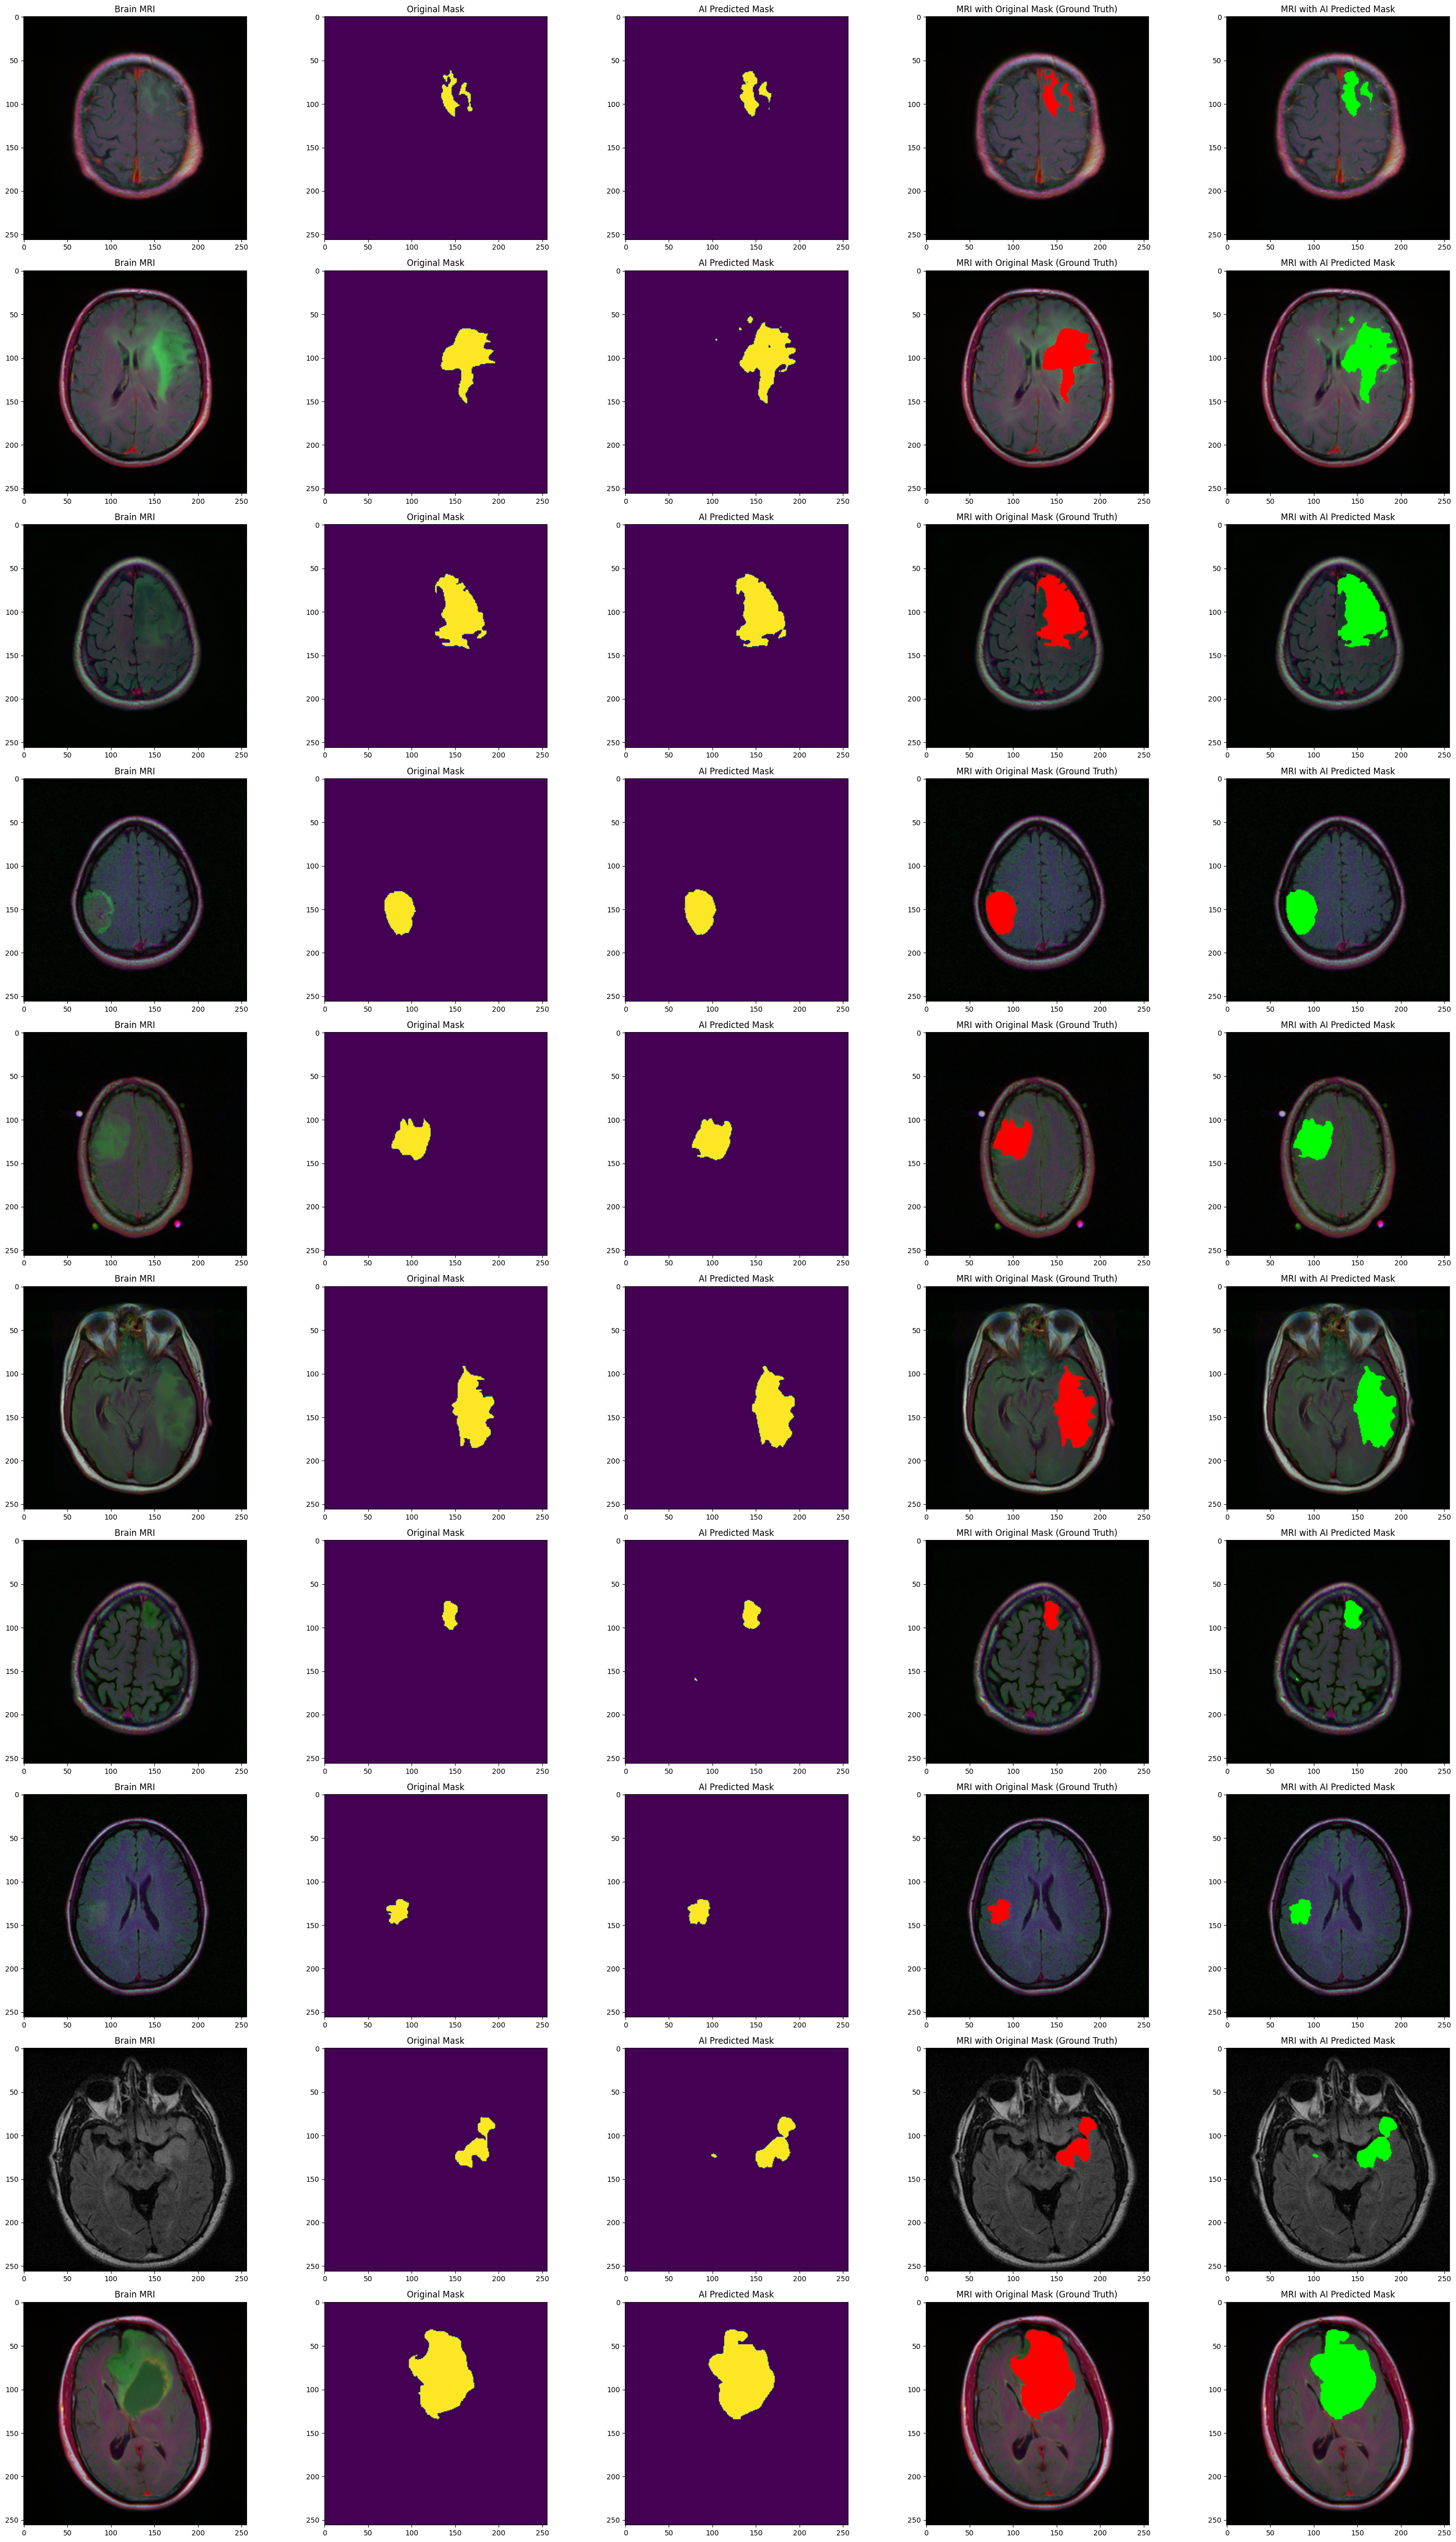

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()